In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
from src.data_preprocess import align_by_price, get_multiplicatively_adjusted_prices, annual_div_yield
from src.preselection import DividendIndexPreSelection, DropNotInIndex

In [3]:
from plotly.io import show
import plotly.express as px
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from skfolio import Population, RiskMeasure, ExtraRiskMeasure, RatioMeasure
from skfolio.uncertainty_set import EmpiricalMuUncertaintySet
# from skfolio.datasets import load_sp500_dataset, load_factors_dataset
from skfolio.model_selection import WalkForward, cross_val_predict
from skfolio.optimization import MeanRisk, ObjectiveFunction, EqualWeighted, HierarchicalRiskParity
from skfolio.metrics import make_scorer
from skfolio.preprocessing import prices_to_returns

import pandas as pd
import numpy as np
import duckdb

## data

In [4]:
with duckdb.connect('../data/main.duckdb') as conn:
    div_data = conn.sql("SELECT * FROM tinvest_dividends").df()
    t_candles = conn.sql("SELECT * FROM tinvest_shares_candles").df()
    m_candles = conn.sql("SELECT * FROM moex_shares_candles").df()
    t_info = conn.sql("SELECT * FROM tinvest_shares_info").df()

In [5]:
short_list = t_info[t_info['figi'].isin(t_candles['figi'].unique())]
figi2ticker = dict(zip(short_list['figi'], short_list['ticker']))
ticker2figi = {v: k for k, v in figi2ticker.items()}

In [6]:
price_data = t_candles.pivot(index = 'time', columns = 'figi', values = 'close')
adj_prices = get_multiplicatively_adjusted_prices(price_data, div_data[div_data['figi'].isin(price_data.columns)])
adj_prices = adj_prices.rename(columns = figi2ticker)

In [7]:
# import datetime
# print(datetime.datetime.now())
# print(str(datetime.datetime.now().nor))
# div_data['record_date'].value_counts()

In [8]:
div_data['ticker'] = div_data['figi'].map(figi2ticker)
div_yield = annual_div_yield(adj_prices, div_data, column='ticker').fillna(0)
pivot_divs = (
    div_data.pivot_table(index='payment_date', columns='ticker', values='yield_value', aggfunc='sum')
    .reindex(columns=adj_prices.columns)
)
# mean_divs = pivot_divs.expanding().mean().fillna(0)
# sum_divs = pivot_divs.expanding().sum().fillna(0)

In [9]:
# show(px.line(mean_divs.sum(axis = 1)))

In [10]:
X = adj_prices.pct_change(fill_method=None).fillna(0)
returns = adj_prices.pct_change(fill_method=None).fillna(0)

In [11]:
index_arr = []
with pd.ExcelFile('../data/imoex_content.xlsx') as xl:
    for sheetname in xl.sheet_names:
        if sheetname == 'help': continue
        tmp = xl.parse(sheetname, skiprows=3)
        weight_col = tmp.columns[tmp.columns.str.startswith('Weight')][0]
        contituents_df = tmp[['Code', weight_col]].copy()
        contituents_df = contituents_df[contituents_df['Code'].isin(X.columns)]
        contituents_df['date'] = pd.to_datetime(sheetname, dayfirst=True)
        contituents_df['added'] = 1*(contituents_df[weight_col].fillna(0) > 0)
        index_arr.append(contituents_df[['Code', 'date', 'added']])
imoex_contituents = pd.concat(index_arr, axis = 0)

In [12]:
universe_mask = imoex_contituents.pivot_table(
    values='added', index='date', columns='Code',
).reindex(columns = X.columns).replace(0, np.nan).ffill().fillna(0)

universe_mask

figi,ELFV,KMAZ,LSNGP,FESH,TGKA,BSPB,FLOT,PLZL,OGKB,ENPG,...,LEAS,EUTR,POSI,VKCO,DELI,YDEX,TCSG,MDMG,BLNG,HEAD
date,,,,,,,,,,,,,,,,,,,,,
2012-12-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-03-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-06-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-09-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-12-17,0.0,0.5,0.0,0.0,0.0,0.5,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-03-18,0.0,0.5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-06-17,0.0,0.5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-09-16,0.0,0.5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-12-16,0.0,0.5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## model

In [13]:
# dividends_sum = pivot_divs.loc[:'2015-10-10'].sum(axis = 0)
# div_q = dividends_sum[universe_mask.loc[:'2015-10-10'].iloc[-1].astype(bool)].quantile(1 - 0.3)
#         # Performance tip: `argpartition` could be used here for better efficiency
#         # (O(n log(n)) vs O(n)).
# div_q

In [43]:
set_config(enable_metadata_routing=True, transform_output="pandas")
model1 = Pipeline(
    [
        ("pre_selection", DropNotInIndex(universe_mask, returns)),
        ("optimization", EqualWeighted()),
    ]
)
model2 = Pipeline(
    [
        ("pre_selection", DividendIndexPreSelection(returns, universe_mask, div_yield, pct_to_keep=0.5)),
        # ("optimization", HierarchicalRiskParity(risk_measure=RiskMeasure.CDAR)),
        ("optimization", MeanRisk(
            risk_measure=RiskMeasure.CDAR,
            objective_function=ObjectiveFunction.MAXIMIZE_RATIO,
            max_weights=0.2, l2_coef=0.001,
            transaction_costs=0.01/60
            # solver_params={'verbose': True}
        ))
    ]
)
model3 = Pipeline(
    [
        ("pre_selection", DividendIndexPreSelection(returns, universe_mask, div_yield, pct_to_keep=0.5)),
        ("optimization", MeanRisk(
            risk_measure=RiskMeasure.CDAR,
            objective_function=ObjectiveFunction.MAXIMIZE_UTILITY, risk_aversion=0.001,
            transaction_costs=0.01/60,
            mu_uncertainty_set_estimator=EmpiricalMuUncertaintySet(confidence_level=0.9)
        )),
    ]
)

## WalkForward

In [26]:
X_train, X_test = train_test_split(X, test_size=0.33, shuffle=False)

In [42]:
grid_search = GridSearchCV(
    estimator=model3,
    cv=cv,
    n_jobs=-1,
    param_grid={
        "optimization__mu_uncertainty_set_estimator__confidence_level": [0.7, 0.8, 0.9],
        "optimization__risk_aversion": [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99],
    },
    scoring=make_scorer(ExtraRiskMeasure.SKEW),
)
grid_search.fit(X_train)
best_model = grid_search.best_estimator_
print(best_model)

Pipeline(steps=[('pre_selection',
                 DividendIndexPreSelection(dividends=figi            ELFV      KMAZ     LSNGP  FESH  TGKA      BSPB      FLOT  \
time                                                                       
2015-12-18  0.169398  0.000000  0.000000   0.0   0.0  0.000000  0.000000   
2015-12-21  0.170127  0.000000  0.000000   0.0   0.0  0.000000  0.000000   
2015-12-22  0.169398  0.000000  0.000000   0.0   0.0  0.000000  0.000000   
2015-12-23  0.170127  0.000000  0.000000   0.0   0.0  0.000000  0.000000   
2015-12-24  0.168196  0...
2024-06-21   0.5   0.0   1.0   1.0   0.0   0.0   1.0   0.0   0.0   0.0  
2024-09-20   1.0   0.0   1.0   1.0   0.0   0.5   1.0   0.0   0.0   0.0  
2024-10-14   1.0   0.0   1.0   1.0   0.0   1.0   1.0   0.0   0.0   0.0  

[51 rows x 83 columns])),
                ('optimization',
                 MeanRisk(mu_uncertainty_set_estimator=EmpiricalMuUncertaintySet(confidence_level=0.9),
                          objective_function=MA

In [44]:
cv = WalkForward(train_size=252, test_size=60)
pred1 = cross_val_predict(model1, X, cv=cv)
pred1.name = 'index'
pred2 = cross_val_predict(model2, X, cv=cv)
pred2.name = 'ver2'
pred3 = cross_val_predict(model3, X, cv=cv)
pred3.name = 'ver3'
# pred4 = cross_val_predict(model4, X, cv=cv)
# pred4.name = 'ext-ver1'

In [16]:
# model2.fit(X)
# pred = model2.predict(X)

In [20]:
# pred.weights_per_observation.reset_index().to_csv('weights.csv', index = False)

In [18]:
# print(model2.named_steps['optimization'].problem_)

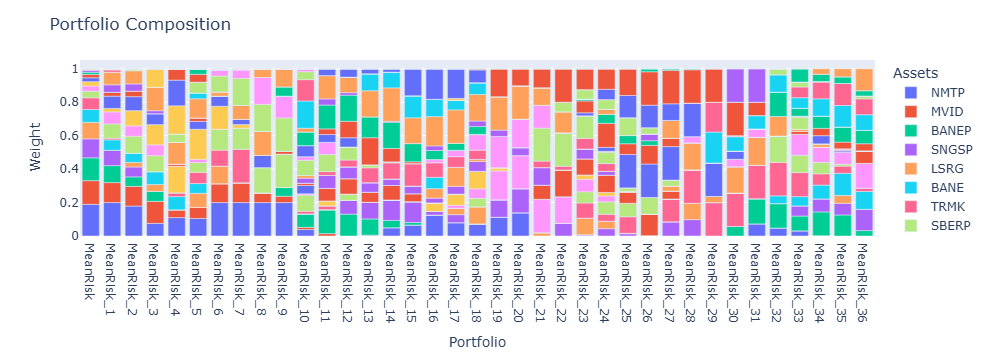

In [41]:
pred2.plot_composition()

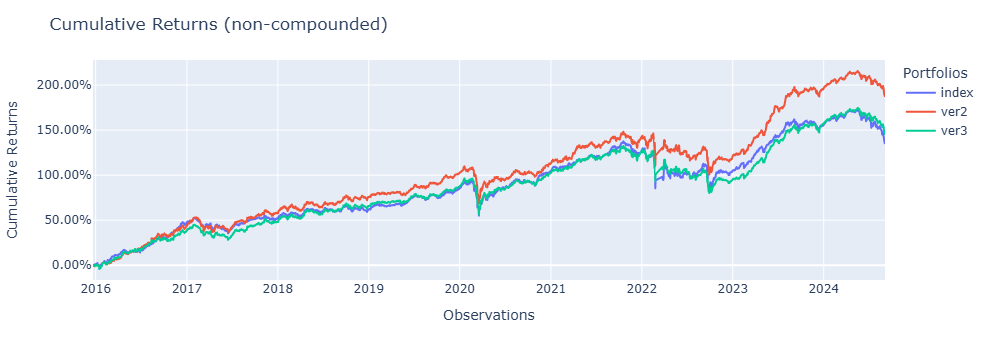

In [45]:
population = Population([pred1, pred2, pred3])
fig = population.plot_cumulative_returns()
show(fig)

In [33]:
population.summary()

/home/mlun/quant_proj/quantenv/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



,index,ver2,ver3
Mean,0.061%,0.085%,0.060%
Annualized Mean,15.40%,21.32%,15.21%
Variance,0.016%,0.018%,0.014%
Annualized Variance,4.08%,4.60%,3.49%
Semi-Variance,0.011%,0.011%,0.0086%
Annualized Semi-Variance,2.71%,2.77%,2.18%
Standard Deviation,1.27%,1.35%,1.18%
Annualized Standard Deviation,20.21%,21.46%,18.68%
Semi-Deviation,1.04%,1.05%,0.93%
Annualized Semi-Deviation,16.45%,16.64%,14.76%


## MultiWalkForward

In [36]:
from cvxpy.error import SolverError

In [37]:
def multi_walkforward(model_list, model_tags, X, train_size, test_size, step = 1):
    population = Population([])
    cv = WalkForward(train_size=train_size, test_size=test_size)
    for model, tag in zip(model_list, model_tags):
        for i in range(0, test_size, step):
            X_val = X.iloc[i:].copy()
            try:
                pred = cross_val_predict(model, X_val, cv=cv, n_jobs=-1, 
                                         portfolio_params=dict(annualized_factor=252, tag=tag))
            except SolverError:
                print(i, tag, 'solver error')
            population.append(pred)
    return population

In [38]:
population = multi_walkforward([model1, model2, model3], ['benchmark', 'model2', 'model3'], X, 252, 60, 3)

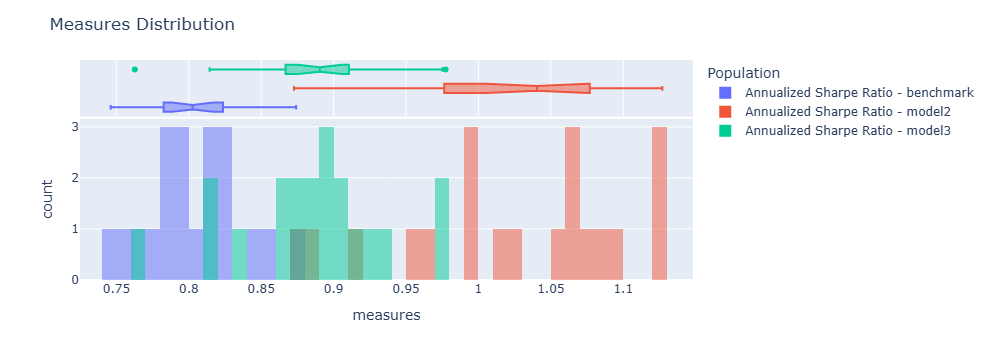

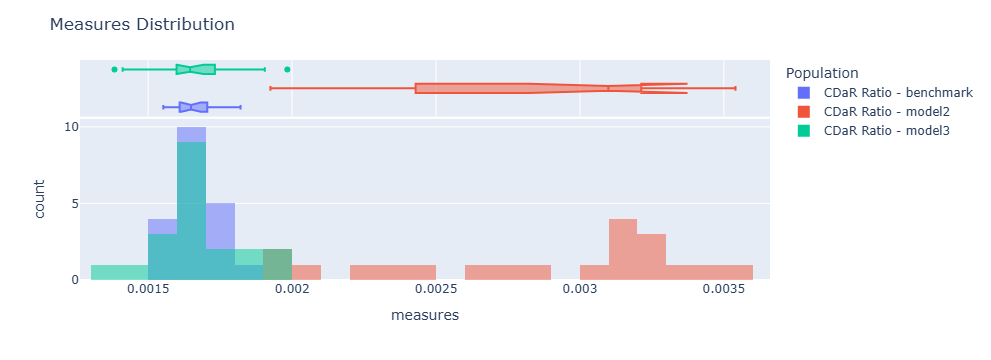

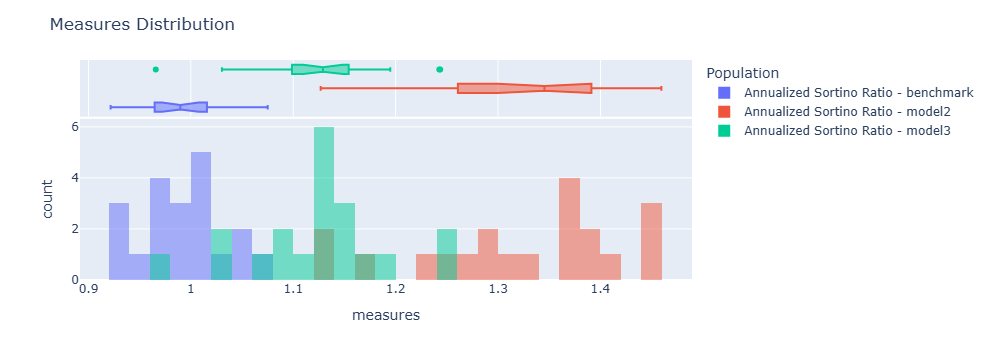

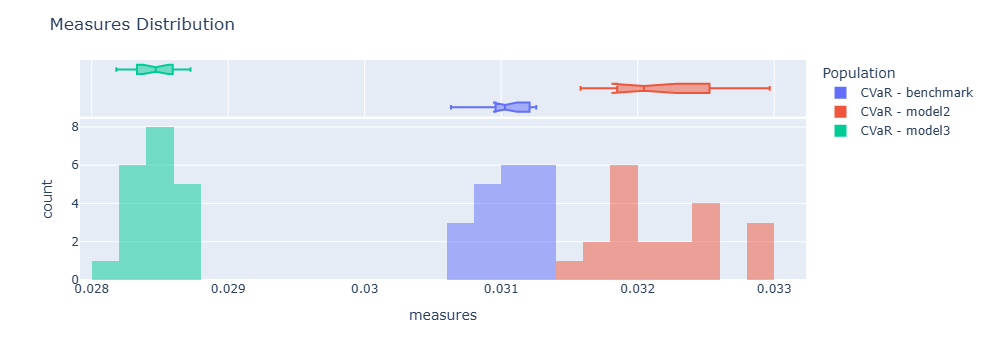

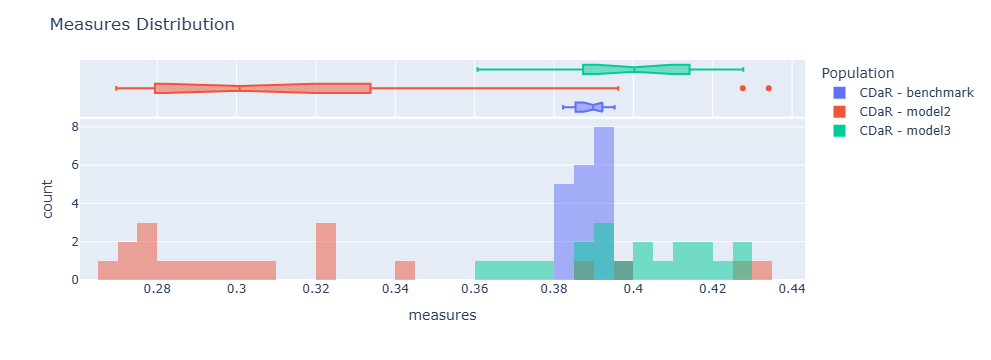

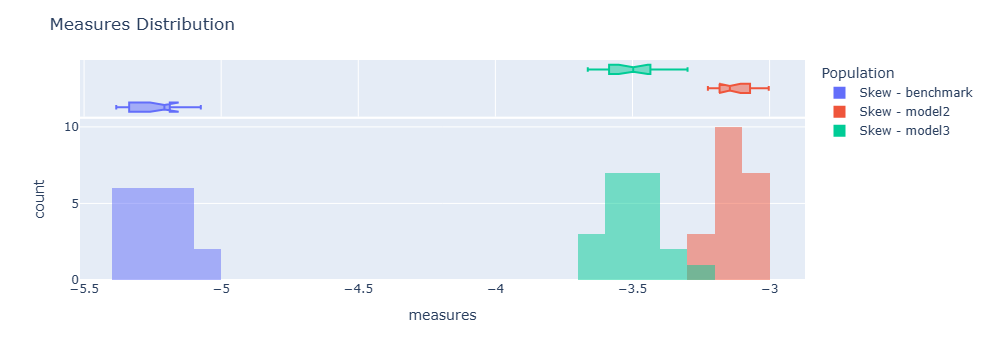

In [39]:
for risk_measure in [RatioMeasure.ANNUALIZED_SHARPE_RATIO,
        RatioMeasure.CDAR_RATIO,
        RatioMeasure.ANNUALIZED_SORTINO_RATIO,
        RiskMeasure.CVAR, 
        RiskMeasure.CDAR,
        ExtraRiskMeasure.SKEW]:
    fig = population.plot_distribution(
        measure_list=[
            risk_measure
        ], tag_list=['benchmark', 'model2', 'model3'], n_bins=40
    )
    show(fig)